In [4]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils
from torchvision import models
import torch.nn.functional as F
from torch import nn, optim 

from PIL import Image
import glob, re, os, copy, random, time

import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class TSAFN(nn.Module):
    def __init__(self):
        super(TSAFN, self).__init__()
        self.conv1 = nn.Sequential(
                    nn.Conv2d(5, 64, 7, 1, 3),
                    nn.BatchNorm2d(64),
                    nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
                    nn.Conv2d(64, 32, 5, 1, 2),
                    nn.BatchNorm2d(32),
                    nn.ReLU(True)
        )
        self.conv3 = nn.Sequential(
                    nn.Conv2d(32, 16, 3, 1, 1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(True)
        )
        self.conv4 = nn.Sequential(
                    nn.Conv2d(16, 3, 5, 1, 2),
                    nn.BatchNorm2d(3)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x.sigmoid()

In [427]:
class TPN(nn.Module):
    def __init__(self):
        super(TPN, self).__init__()
        self.conv1_1 = nn.Sequential(
                      nn.Conv2d(3, 16, 3, 1, 1),
                      nn.BatchNorm2d(16),
                      nn.ReLU(True)
        )
        self.conv1_2 = nn.Sequential(
                      nn.Conv2d(3, 16, 3, 1, 1),
                      nn.BatchNorm2d(16),
                      nn.ReLU(True)
        )
        self.conv1_3 = nn.Sequential(
                      nn.Conv2d(3, 16, 3, 1, 1),
                      nn.BatchNorm2d(16),
                      nn.ReLU(True)
        )
        self.conv1_4 = nn.Sequential(
                      nn.Conv2d(3, 16, 3, 1, 1),
                      nn.BatchNorm2d(16),
                      nn.ReLU(True)
        )
        self.conv2_1 = nn.Sequential(
                      nn.Conv2d(16, 8, 3, 1, 1),
                      nn.BatchNorm2d(8),
                      nn.ReLU(True)
        )
        self.conv2_2 = nn.Sequential(
                      nn.Conv2d(16, 8, 3, 1, 1),
                      nn.BatchNorm2d(8),
                      nn.ReLU(True)
        )
        self.conv2_3 = nn.Sequential(
                      nn.Conv2d(16, 8, 3, 1, 1),
                      nn.BatchNorm2d(8),
                      nn.ReLU(True)
        )
        self.conv2_4 = nn.Sequential(
                      nn.Conv2d(16, 8, 3, 1, 1),
                      nn.BatchNorm2d(8),
                      nn.ReLU(True)
        )
        self.conv3_1 = nn.Sequential(
                      nn.Conv2d(8, 4, 3, 1, 1),
                      nn.BatchNorm2d(4),
                      nn.ReLU(True)
        )
        self.conv3_2 = nn.Sequential(
                      nn.Conv2d(8, 4, 3, 1, 1),
                      nn.BatchNorm2d(4),
                      nn.ReLU(True)
        )
        self.conv3_3 = nn.Sequential(
                      nn.Conv2d(8, 4, 3, 1, 1),
                      nn.BatchNorm2d(4),
                      nn.ReLU(True)
        )
        self.conv3_4 = nn.Sequential(
                      nn.Conv2d(8, 4, 3, 1, 1),
                      nn.BatchNorm2d(4),
                      nn.ReLU(True)
        )
        self.conv4 = nn.Sequential(
                      nn.Conv2d(16, 1, 3, 1, 1),
                      nn.BatchNorm2d(1),
                      nn.Sigmoid()
        )
    def forward(self, x):
        N, C, h, w = x.size()
        
        size1 = x
        size2 = F.interpolate(x, size=(h//2, w//2))
        size4 = F.interpolate(x, size=(h//4, w//4))
        size8 = F.interpolate(x, size=(h//8, w//8))
        
        size1 = self.conv1_1(size1)
        size2 = self.conv1_2(size2)
        size4 = self.conv1_3(size4)
        size8 = self.conv1_4(size8)
        
        size1 = self.conv2_1(size1)
        size2 = self.conv2_2(size2)
        size4 = self.conv2_3(size4)
        size8 = self.conv2_4(size8)
        
        size1 = self.conv3_1(size1)
        size2 = self.conv3_2(size2)
        size4 = self.conv3_3(size4)
        size8 = self.conv3_4(size8)
        
        size2 = F.interpolate(size2, size=(h,w))
        size4 = F.interpolate(size4, size=(h,w))
        size8 = F.interpolate(size8, size=(h,w))
        
        concat = torch.cat((size1, size2, size4, size8), 1)
        
        return self.conv4(concat) 

In [670]:
def TPN_one_iter(model, data_loader, optimizer=None):
    assert model.__class__.__name__ == 'TPN', 'this TPN_one_iter only works for TPN model' 
    
    if optimizer:
        is_train = True
    else:
        is_train = False
        
    loss_sum = 0
    criterion = nn.MSELoss()
    for x in data_loader:
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            out = model(x['input'].to(device))
            loss = criterion(out, x['TPN'].to(device)).to(device)
            if is_train:
                loss.backward()
                optimizer.step()
        loss_sum += loss
    epoch_loss = loss_sum / len(train_loader)
    return epoch_loss

def weighted_cross_entropy(pred, target):
    total = target.numel()  # it is int
    negative = (target == 0).sum().item()  # it is tensor before call .item() 
    
    mask = torch.empty_like(target, dtype=torch.float)
    mask[target == 0] = 1 - negative / total
    mask[target != 0] = negative / total
    
    # If rigorously follow what the HED paper did, argument reduction='sum' should be added. 
    # However, to make all losses under small scale, we remove it. Same for BCEWithLogitsLoss below. 
    return F.binary_cross_entropy_with_logits(pred, target, mask)


def SPN_loss(so1, so2, so3, so4, so5, fusion, target):
    # non-weighted BCE
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(fusion, target) 

    # there are weights called alpha mentioned in paper which is used to combine 
    # the side output loss summation. However, no further description about alpha
    # thus here just simply sum them together without weights.

    loss += weighted_cross_entropy(so1, target)
    loss += weighted_cross_entropy(so2, target)
    loss += weighted_cross_entropy(so3, target)
    loss += weighted_cross_entropy(so4, target)
    loss += weighted_cross_entropy(so5, target)

    return loss


def SPN_one_iter(model, data_loader, optimizer=None):
    assert model.__class__.__name__ == 'SPN', 'this SPN_one_iter only works for SPN model' 
    if optimizer:
        is_train = True
    else:
        is_train = False
    
    loss_sum = 0
    for x in data_loader:
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            output = model(x['input'].to(device))
            target = x['TPN'].to(device)
            
            loss = SPN_loss(*output, target).to(device)

            if is_train:
                loss.backward()
                optimizer.step()
        loss_sum += loss
        
    epoch_loss = loss_sum / len(train_loader)
    return epoch_loss

def TSAFN_one_iter(model, data_loader, optimizer=None):
    assert model.__class__.__name__ == 'TSAFN', 'this TSAFN_one_iter only works for TSAFN model' 
    
    if optimizer:
        is_train = True
    else:
        is_train = False
    
    criterion = nn.MSELoss()
    loss_sum = 0
    for x in data_loader:
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            inpu = torch.cat((x['input'].to(device), x['TPN'].to(device), x['SPN'].to(device)), 1)
            out = model(inpu)
            loss = criterion(out, x['TSAFN'].to(device)).to(device)
            if is_train:
                loss.backward()
                optimizer.step()
        loss_sum += loss
    epoch_loss = loss_sum / len(train_loader)
    return epoch_loss


def three_to_one(model_dict, data_loader, optimizer=None):
    TPN = model_dict['TPN']
    SPN = model_dict['SPN']
    TSAFN = model_dict['TSAFN']

    if optimizer:
        is_train = True
    else:
        is_train = False
    
    criterion = nn.MSELoss()
    loss_sum = 0
    for x in data_loader:
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            inpu = x['input'].to(device)
            target_TPN = x['TPN'].to(device)
            target_SPN = x['SPN'].to(device)
            target_TSAFN = x['TSAFN'].to(device)
            
            output_TPN = TPN(inpu)
            output_SPN = SPN(inpu)
            concat = torch.cat((inpu, output_TPN, output_SPN[-1]), 1) # what really counts for SPN is fusion output 
            out = TSAFN(concat)
            
            loss_SPN = SPN_loss(*output_SPN, target_SPN)
            loss_TPN = F.mse_loss(output_TPN, target_TPN)
            loss_TSAFN = F.mse_loss(out, target_TSAFN)
            print(loss_SPN)
            print(loss_TPN)
            print(loss_TSAFN)
            loss = 0.6 * loss_TSAFN + 0.2 * (loss_SPN + loss_TPN)
            loss = loss.to(device)
            print(loss)
            if is_train:
                loss.backward()
                optimizer.step()
        loss_sum += loss
    epoch_loss = loss_sum / len(train_loader)
    return epoch_loss

    

def train(model, model_iter, train_loader, val_loader, optimizer=None, epochs=500, save_interval=2):
    start_time = time.time()
    
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        epoch_time = time.time()
        train_loss = model_iter(model, train_loader, optimizer)
        val_loss = model_iter(model, val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        epoch_time = time.time() - epoch_time

        if (epoch + 1) % 1 == 0:
            print("Epoch {} finished, current loss is {} takes {}".format(epoch + 1, val_loss, 
                                                                          timeformat(epoch_time)))
            print('It takes {} from beginning'.format(timeformat(time.time() - start_time)))
            
        if (epoch + 1) % save_interval == 0:
            torch.save(model, '{}epoch_result'.format(epoch + 1))
        
    return train_losses, val_losses

def timeformat(s):
    s = int(s)
    m, s = divmod(s, 60)
    h, m = divmod(m, 60)
    t = '{:>02d}:{:>02d}:{:>02d}'.format(h, m, s) if h else '{:>02d}:{:>02d}'.format(m, s) if m else '{:2d}s'.format(s)
    return t

In [576]:
class SPN(nn.Module):
    def __init__(self, body_model='vgg11'):
        super(SPN, self).__init__()
        
        self.body = VGGNet(model=body_model)
        
        self.side_output_layer1 = nn.Conv2d(64, 1, 1)
        self.side_output_layer2 = nn.Conv2d(128, 1, 1)
        self.side_output_layer3 = nn.Conv2d(256, 1, 1)
        self.side_output_layer4 = nn.Conv2d(512, 1, 1)
        self.side_output_layer5 = nn.Conv2d(512, 1, 1)
        
        self.fusion = nn.Conv2d(5, 1, 1)
        
    def forward(self, x):
        N, C, h, w = x.size()
        
        # load vgg
        body = self.body(x)

        # side-output layers
        side_output1 = body['side_output1']
        side_output1 = self.side_output_layer1(side_output1)
        side_output1 = F.interpolate(side_output1, size=(h, w))
        
        side_output2 = body['side_output2']
        side_output2 = self.side_output_layer2(side_output2)
        side_output2 = F.interpolate(side_output2, size=(h,w))
        
        side_output3 = body['side_output3']
        side_output3 = self.side_output_layer3(side_output3)
        side_output3 = F.interpolate(side_output3, size=(h,w))
        
        side_output4 = body['side_output4']
        side_output4 = self.side_output_layer4(side_output4)
        side_output4 = F.interpolate(side_output4, size=(h,w))
        
        side_output5 = body['side_output5']
        side_output5 = self.side_output_layer5(side_output5)
        side_output5 = F.interpolate(side_output5, size=(h,w))
        
        # fusion layer
        fuse = torch.cat((side_output1, side_output2, side_output3, side_output4, side_output5), 1)
        fusion = self.fusion(fuse)

        # will use cross_entropy_with_logit loss, so no need apply sigmoid on the final output.
        return side_output1, side_output2, side_output3, side_output4, side_output5, fusion


# the strategy to both get the structure and pretrained weight of in-built vgg
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg11', requires_grad=True):
  
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.{}_bn(pretrained=True).state_dict())".format(model))
        
        # for fix weight transfor learning
        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False
                
        # first reconstructure same vgg structure as in-bulit to utilize pretraining, but del the redundent fc later
        del self.classifier  

    def forward(self, x):
        output = {}

        # catch the middle outputs 
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            
            output["side_output%d"%(idx+1)] = x

        return output

# this range only for batchnorm version
ranges = {
    'vgg11': ((0, 3), (3, 7),  (7, 14),  (14, 21), (21, 28)),
    'vgg13': ((0, 6), (6, 13), (13, 20), (20, 27), (27, 34)),
    'vgg16': ((0, 6), (6, 13), (13, 23), (23, 32), (32, 43)),
    'vgg19': ((0, 6), (6, 13), (13, 26), (26, 39), (39, 52))
}

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [50]:
class SmoothData(Dataset):
    def __init__(self, path, split_ratio={'train':0.65, 'val':0.1, 'test':0.25}, transform=None):
        self.transforms = transform
        self.category = {}
        self.name = {'input', 'target_SPN', 'target_TPN', 'target_TSAFN'}
        self.mode = None
        self.modeset = ['train', 'val', 'test']
        
        check_folder = set()
        for directory, folders, _ in os.walk(path):
            for f in folders:
                self.category[f] = glob.glob(os.path.join(directory, f) + '\\*')
                check_folder.add(f)
            break  # only retrieve one level
            
        assert not (self.name - check_folder), 'folder name must be same as declared in self.name'
        assert sum(split_ratio.values()) == 1, 'the summation of values in split_ratio must be one'

        self.total = len(self.category['input'])
        
        index_shuffle = list(range(self.total))
        random.shuffle(index_shuffle)
        
        train_amount = int(self.total * split_ratio['train'])
        val_amount = int(self.total * split_ratio['val'])
        self.amount = {'train': train_amount,
                       'val': val_amount,
                       'test': self.total - train_amount - val_amount}  # must use minus, otherwise not full.         

        index_train = index_shuffle[: self.amount['train']]
        index_val = index_shuffle[self.amount['train'] : self.amount['train'] + self.amount['val']]
        index_test = index_shuffle[self.amount['train'] + self.amount['val'] :]

        
        # the file retrieval order is not sequentially from 1 to end, but may be like 1, 10, 11, ... , 2, 20 ..
        # this part is to align the image index into sequential order for target_SPN and target_TSAFN
        target_length = len(self.category['target_SPN'])
        temp1 = [0 for i in range(target_length)]
        temp2 = copy.deepcopy(temp1)
        for i in range(target_length):
            img_path = self.category['target_SPN'][i]
            _, img_name = os.path.split(img_path)
            img_index = int(img_name.split('.')[0])
            temp1[img_index] = img_path
            
            img_path = self.category['target_TSAFN'][i]
            _, img_name = os.path.split(img_path)
            img_index = int(img_name.split('.')[0])
            temp2[img_index] = img_path
        self.category['target_SPN'] = temp1
        self.category['target_TSAFN'] = temp2
        
        self.collection = {'train':([[0 for i in range(4)] for i in range(self.amount['train'])], index_train),
                           'val':([[0 for i in range(4)] for i in range(self.amount['val'])], index_val),
                           'test':([[0 for i in range(4)] for i in range(self.amount['test'])], index_test)}
        
        for m in self.modeset:
            for subset_index, alldata_index in enumerate(self.collection[m][1]):
                _, img_name = os.path.split(self.category['input'][alldata_index])
                img_index = int(img_name.split('_')[0])

                self.collection[m][0][subset_index] = [self.category['input'][alldata_index], 
                                      self.category['target_TPN'][alldata_index], 
                                      self.category['target_SPN'][img_index], 
                                      self.category['target_TSAFN'][img_index]]  

    def __call__(self, mode):
        assert mode in self.modeset, 'mode must be either train, val or test'
        self.mode = mode
        return self
    
    def __len__(self):
        if self.mode:
            return self.amount[self.mode]
        else:
            raise Exception('Firstly, you must use self.setmode(mode) to set which data set (train, val, test) to be use.')
            
    def __getitem__(self, i):
        # check if mode is set
        len(self)
       
        dataset = self.collection[self.mode][0]
        inpu = Image.open(dataset[i][0])
        target_TPN = Image.open(dataset[i][1])
        target_SPN = Image.open(dataset[i][2])
        target_TSAFN = Image.open(dataset[i][3])
        
        if self.transforms:
            inpu = self.transforms(inpu)
            target_TPN = self.transforms(target_TPN)
            target_SPN = self.transforms(target_SPN)
            target_TSAFN = self.transforms(target_TSAFN)

        return {'input':inpu, 'TPN':target_TPN, 'SPN':target_SPN, 'TSAFN':target_TSAFN}

In [51]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                                      transforms.ToTensor()])

data = SmoothData('../verysmall_dataset', transform=transform)  

#train_sampler = sampler.SubsetRandomSampler(range(18000))
#val_sampler = sampler.SubsetRandomSampler(range(18000, 20000))

train_loader = DataLoader(data('train'), batch_size=2)
val_loader = DataLoader(data('val'), batch_size=10)
test_loader = DataLoader(data('test'), batch_size=10)

In [137]:
from skimage import io, img_as_float, img_as_uint, transform
img1 = img_as_float(io.imread('../verysmall_dataset/input/4_0.jpg'))
img2 = img_as_float(transform.resize(io.imread('../verysmall_dataset/target_TSAFN/4.jpg'), (400, 400, 3)))

img = abs(img1 - img2)
img = img.sum(2)

io.imsave('tanhtimes.jpg', np.tanh(img))


D:\programming_tools\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\programming_tools\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [143]:
a = torch.zeros(2,3,3,3)
for i in a:
    print(i)

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])


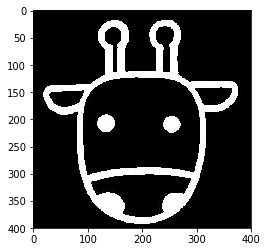

In [72]:
from torchvision import utils 
img = data('train')[-1]['SPN']
img = img.expand(3,-1,-1).transpose(0, 2).transpose(0,1)
plt.imshow(img)

In [671]:
%%time
model_dict = {'SPN': SPN().to(device), 'TPN': TPN().to(device), 'TSAFN': TSAFN().to(device)} 
#model = torch.load('9epoch_result')

optimizer = optim.Adam(model.parameters(), 1e-3)

loss, val_losses = train(model_dict, three_to_one, train_loader, val_loader, optimizer=optimizer)

tensor(1.2999, grad_fn=<ThAddBackward>)
tensor(0.1707, grad_fn=<MseLossBackward>)
tensor(0.1392, grad_fn=<MseLossBackward>)
tensor(0.3776, grad_fn=<ThAddBackward>)


RuntimeError: $ Torch: not enough memory: you tried to allocate 1GB. Buy new RAM! at ..\aten\src\TH\THGeneral.cpp:204

In [220]:
transform = transforms.Compose([transforms.ToTensor()])
a = SmoothData('D:\smooth_net\data', transform=transform)[3]
#c = utils.make_grid(torch.cat((a[0], a[1], a[2], a[3]), 2))
c1 = a[0].numpy().transpose((1,2,0))
c2 = a[1].numpy().transpose((1,2,0))
c3 = a[2].numpy().transpose((1,2,0))
c4 = a[3].numpy().transpose((1,2,0))
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(c1)
plt.subplot(142)
plt.imshow(c2[:,:,0], cmap='gray')
plt.subplot(143)
plt.imshow(c3[:,:,0], cmap='gray')
plt.subplot(144)
plt.imshow(c4)

(400, 400)


NameError: name 'img' is not defined